# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [2]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def train_model(model, hyperparameters, 
                grid_search = False):
    """Wrapper for training models with optional grid search and feature selection.
    Pass model with no brackets, ie Lars not Lars()
    If grid_search = True, hyperparameters is the hp ranges dictionary. Outputs trained model, best_hp
    If grid_search = False, hyperparameters is the hp dictionary. Outputs trained model"""
    
    if grid_search == True:
        best_hp = grid_search_return_hp_dict(model(),
                                             X_train, y_train, hyperparameters)
        print("Grid search complete!\nHyperparameters:\n", best_hp)
        training_model = model(**best_hp).fit(X_train, y_train)
        return training_model, best_hp

    if grid_search == False:
        print("No grid search\nHyperparameters:\n", hyperparameters)
        training_model = model(**hyperparameters).fit(X_train, y_train)
        return training_model

def produce_exp_vs_pred_df(model, codename): # generalise!
    
    pred_list = model.predict(pca_features_all)
    
    exp_vs_calc = pd.DataFrame(constants_first)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    exp_vs_calc.to_csv('models/PCA_DRAGON_VPAS/%s'%("expvcalc_" + str(model).split(sep='(')[0] + ".csv"))
    now = datetime.now()

    dt_string = now.strftime("_%d_%m_%Y_%H_%M_%S")
    filename = "models/PCA_DRAGON_VPAS/" + str(model).split(sep='(')[0] + "_" + dt_string + ".joblib"
    print(str(model).split(sep='(')[0], "run at:", now, ". Saving to", filename)
    
    joblib.dump(model, filename)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [14]:
csv = pd.read_csv('filtered_organics_desc_kh.csv') # contains VP/AS HLCs

print("Input Shape", csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print("Removed NaN, new shape", csv.shape) #removed NaN shape

smiles_strings = csv.pop('Unnamed: 0')
species_names = csv.pop('0')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features


X_train, X_test, y_train, y_test = train_test_split(dragon_features, constants_first, test_size=0.3)

Input Shape (2075, 1480)
Removed NaN, new shape (2068, 1480)


## PCA

In [17]:
pca_standard_x_train = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=250)
pca_fit = pca.fit(pca_standard_x_train)
pca_components_train = pca_fit.transform(pca_standard_x_train)
pca_features_train = pd.DataFrame(data = pca_components_train)
X_train = pca_features_train

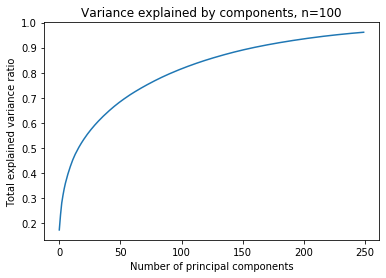

In [18]:
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.ylabel('Total explained variance ratio')
plt.title('Variance explained by components, n=100')

plt.savefig('scree_plot100.png')

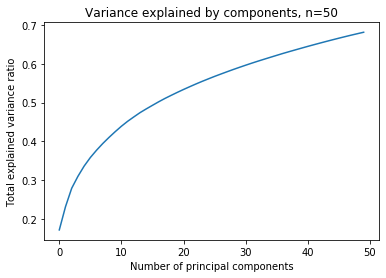

None

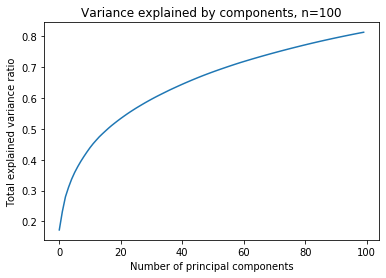

None

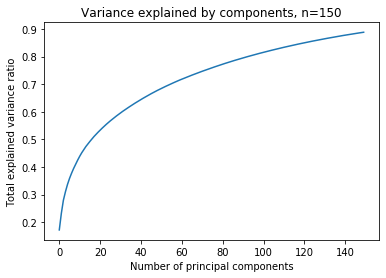

None

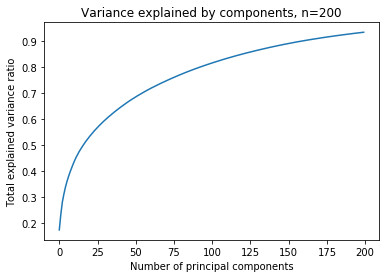

None

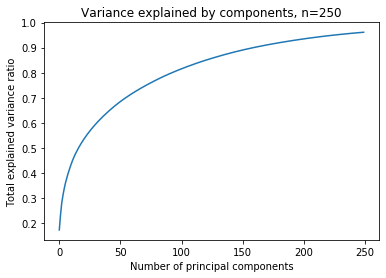

None

In [15]:
for n_comp in [50, 100, 150, 200, 250]:
    pca_standard_x_train = StandardScaler().fit_transform(X_train)
    pca = PCA(n_components=n_comp)
    pca_fit = pca.fit(pca_standard_x_train)
    plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
    plt.xlabel('Number of principal components')
    plt.ylabel('Total explained variance ratio')
    plt.title('Variance explained by components, n=%s'%str(n_comp))
    
    plt.savefig('scree_plot_%s.png'%str(n_comp))
    display(plt.show())

In [19]:
pca_standard_x_test = StandardScaler().fit_transform(X_test)
pca_components_test = pca_fit.transform(pca_standard_x_test)

pca_features_test = pd.DataFrame(data = pca_components_test)
X_test = pca_features_test

In [9]:
pca_standard_x_all = StandardScaler().fit_transform(dragon_features)
pca_components_all = pca_fit.transform(pca_standard_x_all)

pca_features_all = pd.DataFrame(data = pca_components_all)

## GradientBoosting
### Model-chosen features

In [21]:
hp_dict = {'learning_rate': 0.05, 
                            'loss': 'huber', 
                            'max_depth': 6, 
                            'max_features': 0.3, 
                            'min_samples_leaf': 3, 
                            'n_estimators': 500}
gbr_model, gbr_hp = train_model(model = GradientBoostingRegressor,
            grid_search=False,
           hyperparameters=hp_dict)

exp_vs_calc_gbr_model = produce_exp_vs_pred_df(gbr_model,
                                         "GradBoost")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 500}


ValueError: too many values to unpack (expected 2)

## Decision Tree
### Model-Chosen Features

In [11]:
dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
} #hyperparameters for dtr gridsearch

In [12]:
dtr_model, dtr_hp = train_model(model = DecisionTreeRegressor,
            grid_search=True,
           hyperparameters=dtr_param_grid)


exp_vs_calc_dtr_model = produce_exp_vs_pred_df(dtr_model,
                                         "Decision Tree")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Grid search complete!
Hyperparameters:
 {'criterion': 'mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
DecisionTreeRegressor run at: 2020-01-27 10:44:12.548657 . Saving to models/PCA_DRAGON_VPAS/DecisionTreeRegressor__27_01_2020_10_44_12.joblib


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## AdaBoost Regressor
### Model Chosen Features

In [13]:
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3),
              GradientBoostingRegressor(),
              DecisionTreeRegressor(),
              Lars(),
              ElasticNet()]

ada_param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
} #hyperparameters for adaboost gridsearch

In [14]:
ada_model, ada_hp = train_model(model = AdaBoostRegressor,
            grid_search=True,
           hyperparameters=ada_param_grid)

exp_vs_calc_ada_model = produce_exp_vs_pred_df(ada_model,
                                               "AdaBoost")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'base_estimator': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 50}
Grid search complete!
Hyperparameters:
 {'base_estimator': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
  

## LASSO
### Model Chosen Features

In [15]:
lasso_param_grid = {
    'alpha':[0.2, 0.4, 0.6, 0.8],
    'max_iter':[1000, 5000, 10000, 50000],
    'selection':['cyclic', 'random']
}

In [16]:
lasso_model, lasso_hp = train_model(model = Lasso,
            grid_search=True,
           hyperparameters=lasso_param_grid)


exp_vs_calc_lasso_model = produce_exp_vs_pred_df(lasso_model,
                                                 "LASSO")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.6, 'max_iter': 5000, 'selection': 'random'}
Grid search complete!
Hyperparameters:
 {'alpha': 0.6, 'max_iter': 5000, 'selection': 'random'}
Lasso run at: 2020-01-27 11:09:51.441253 . Saving to models/PCA_DRAGON_VPAS/Lasso__27_01_2020_11_09_51.joblib


## Random Forest Regressor
### Model Chosen Features

In [17]:
random_forest_param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

In [18]:
random_forest_model, rfr_hp = train_model(model = RandomForestRegressor,
            grid_search=True,
           hyperparameters=random_forest_param_grid)
exp_vs_calc_random_forest_model = produce_exp_vs_pred_df(random_forest_model,
                                                         "RandomForest")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Grid search complete!
Hyperparameters:
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
RandomForestRegressor run at: 2020-01-27 19:18:46.645327 . Saving to models/PCA_DRAGON_VPAS/RandomForestRegressor__27_01_2020_19_18_46.joblib


## LARS - Least angle regression
### Model chosen features

In [19]:
lars_param_grid = {'n_nonzero_coefs': [0, 5, 10, 15]}

In [20]:
lars_model, lars_hp = train_model(model = Lars,
            grid_search=True,
           hyperparameters= lars_param_grid)
exp_vs_calc_lars_model = produce_exp_vs_pred_df(lars_model, "LARS")

Lars grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_nonzero_coefs': 15}
Grid search complete!
Hyperparameters:
 {'n_nonzero_coefs': 15}
Lars run at: 2020-01-27 19:19:11.974017 . Saving to models/PCA_DRAGON_VPAS/Lars__27_01_2020_19_19_11.joblib


## Elastic Net (linear regression l1 l2 norm regularization)
### Model chosen features

In [21]:
net_param_grid = {
    'alpha':[0.1, 0.3, 0.5, 0.8, 1.0],
    'l1_ratio':[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'fit_intercept':[True, False],
    'max_iter': [1000, 3000, 5000],
    'tol':[0.0001, 0.001, 0.01],
    'selection':['cyclic', 'random']
}

In [22]:
net_model, net_hp = train_model(model = ElasticNet,
            grid_search=True,
           hyperparameters= net_param_grid)
exp_vs_calc_net_model = produce_exp_vs_pred_df(net_model, "ElasticNet")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.8, 'fit_intercept': True, 'l1_ratio': 0.6, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
Grid search complete!
Hyperparameters:
 {'alpha': 0.8, 'fit_intercept': True, 'l1_ratio': 0.6, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
ElasticNet run at: 2020-01-27 19:20:09.935340 . Saving to models/PCA_DRAGON_VPAS/ElasticNet__27_01_2020_19_20_09.joblib
